In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torch.backends.cudnn as cudnn

from torch.autograd import Function

import matplotlib.pyplot as plt

import load_mnist_data
import data_visualization

In [2]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [3]:
class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=5),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(2),
                    nn.ReLU(True),
                    nn.Conv2d(64, 50, kernel_size=5),
                    nn.BatchNorm2d(50),
                    nn.Dropout2d(),
                    nn.MaxPool2d(2),
                    nn.ReLU(True)
                )
                
        self.avgpool=nn.AdaptiveAvgPool2d((5,5))
        self.classifier = nn.Sequential(
                    nn.Linear(50 * 4 * 4, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(100, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Linear(100, 10),
                )


        self.domain_classifier = nn.Sequential(
                    nn.Linear(50 * 4 * 4, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Linear(100, 2),
                )
    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output


In [4]:
class DANN_with_autoencoder(nn.Module):
    def __init__(self):
        super(DANN_with_autoencoder, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(50, 64, 5, stride=2, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, 5, stride=2, output_padding=1),
            nn.InstanceNorm2d(3),
            nn.ReLU(inplace=True),

            nn.Tanh()
        )
    
        self.classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4* 4, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
        )
        
    def forward(self, input_data, alpha):
            input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
            feature = self.feature(input_data)

            reconstructed_data = self.decoder(feature)
            feature = feature.view(-1, 50 * 4 * 4)
            reverse_feature = ReverseLayerF.apply(feature, alpha)
            class_output = self.classifier(feature)
            domain_output = self.domain_classifier(reverse_feature)

            return class_output, domain_output, reconstructed_data

In [5]:
def train(source, target, net, criterion, optimizer, epoch, use_cuda=True):
    net.train() # Sets the module in training mode.

    train_loss = 0
    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0
    total = 0
    batch_size = 128

    data_target_iter = iter(target)
    len_dataloader = min(len(source), len(target))

    for batch_idx, (inputs, source_label) in enumerate(source):

        p = float(batch_idx + epoch * len_dataloader) / (200 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        batch_size = inputs.size(0)
        total += batch_size

        # Feed source image to the network
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda:
            inputs, source_label, domain_label = inputs.cuda(), source_label.cuda(), domain_label.cuda()
            
        optimizer.zero_grad()
        inputs, source_label = Variable(inputs), Variable(source_label)
        
        class_output, domain_output = net(inputs, alpha)
        
        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()
        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)

        # Feed target image to the network
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda:
            target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        class_output, domain_output = net(target_inputs, alpha)
        loss_t_domain = criterion(domain_output, domain_label)

        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()
        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        loss = loss_s_label + loss_s_domain + loss_t_domain
        loss.backward()
        optimizer.step()
    
    return correct_source_label, correct_source_domain, correct_target_label, correct_target_domain, total


In [6]:
def train_with_autoencoder(source, target, net, criterion,criterion_construct, optimizer, use_cuda, epoch):
    net.train() # Sets the module in training mode.
    total = 0
    data_target_iter = iter(target)

    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0

    len_dataloader = min(len(source), len(target))

    for batch_idx, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        total += batch_size
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoch * len_dataloader) / (200 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda: source_inputs, source_label, domain_label = source_inputs.cuda(), source_label.cuda(), domain_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        class_output, domain_output, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Source image
        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Source images
        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)
        loss_construct_ss = criterion_construct(reconstruct_source, source_inputs)
        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda: target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        class_output, domain_output, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        # Update the label classification accuracy and domain classification accuracy for Target image
        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()

        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        # Calculate the loss of Target images
        loss_construct_tt = criterion_construct(reconstruct_target, target_inputs)
        loss_t_domain = criterion(domain_output, domain_label)

        loss = loss_s_label + loss_s_domain + loss_t_domain + loss_construct_tt + loss_construct_ss

        loss.backward()
        optimizer.step()


    if (epoch % 10 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, correct_source_label/total, correct_source_domain/total, correct_target_label/total, correct_target_domain/total))



In [7]:
loader_source, loader_target = load_mnist_data.get_data_loader(1)

In [8]:
criterion = nn.CrossEntropyLoss()

net = DANN()
if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    net.cuda()
    criterion = criterion.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=0.001) 

for epoch in range(0, 201):
    sl, sd, tl, td, total = train(loader_source, loader_target, net, criterion, optimizer, epoch) 

    if (epoch % 10 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

e: 0, sl: 0.824200, sd: 0.783200, tl: 0.369167, td: 0.755800
e: 10, sl: 0.937300, sd: 0.721133, tl: 0.589900, td: 0.718167
e: 20, sl: 0.937833, sd: 0.684317, tl: 0.669117, td: 0.677017
e: 30, sl: 0.938767, sd: 0.658383, tl: 0.698417, td: 0.651350
e: 40, sl: 0.939200, sd: 0.644433, tl: 0.721183, td: 0.640083
e: 50, sl: 0.940983, sd: 0.641417, tl: 0.732983, td: 0.636033
e: 60, sl: 0.941167, sd: 0.632917, tl: 0.747200, td: 0.628367
e: 70, sl: 0.945417, sd: 0.636717, tl: 0.755683, td: 0.626117
e: 80, sl: 0.945683, sd: 0.629183, tl: 0.754400, td: 0.623917
e: 90, sl: 0.949217, sd: 0.628317, tl: 0.761550, td: 0.623600
e: 100, sl: 0.946433, sd: 0.620050, tl: 0.767117, td: 0.614517
e: 110, sl: 0.950333, sd: 0.621717, tl: 0.772183, td: 0.614067
e: 120, sl: 0.950167, sd: 0.620283, tl: 0.771983, td: 0.610683
e: 130, sl: 0.952350, sd: 0.622933, tl: 0.778800, td: 0.612967
e: 140, sl: 0.954117, sd: 0.620067, tl: 0.782067, td: 0.613750
e: 150, sl: 0.956550, sd: 0.624650, tl: 0.782567, td: 0.616583
e: 

In [9]:
criterion = nn.CrossEntropyLoss()
criterion_construct = torch.nn.L1Loss()
net = DANN_with_autoencoder()

if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    net.cuda()
    criterion = criterion.cuda()
    criterion_construct = criterion_construct.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=0.001) 


In [10]:
for epoch in range(0, 201):
    train_with_autoencoder(loader_source, loader_target, net, criterion, criterion_construct, optimizer, True, epoch) 

e: 0, sl: 0.814533, sd: 0.788583, tl: 0.377200, td: 0.748067
e: 10, sl: 0.936717, sd: 0.741833, tl: 0.546400, td: 0.737850
e: 20, sl: 0.936317, sd: 0.698300, tl: 0.578067, td: 0.687017
e: 30, sl: 0.939217, sd: 0.673850, tl: 0.596717, td: 0.670433
e: 40, sl: 0.935783, sd: 0.657300, tl: 0.612783, td: 0.653200
e: 50, sl: 0.938500, sd: 0.647583, tl: 0.617667, td: 0.645267
e: 60, sl: 0.941067, sd: 0.640833, tl: 0.628133, td: 0.640100
e: 70, sl: 0.941850, sd: 0.639200, tl: 0.638017, td: 0.636300
e: 80, sl: 0.941850, sd: 0.632883, tl: 0.644767, td: 0.632017
e: 90, sl: 0.942833, sd: 0.632117, tl: 0.658500, td: 0.627383
e: 100, sl: 0.945117, sd: 0.629600, tl: 0.664733, td: 0.624267
e: 110, sl: 0.945650, sd: 0.629617, tl: 0.667850, td: 0.625250
e: 120, sl: 0.948133, sd: 0.622117, tl: 0.668950, td: 0.624833
e: 130, sl: 0.948517, sd: 0.624517, tl: 0.677733, td: 0.623450
e: 140, sl: 0.947983, sd: 0.623100, tl: 0.689000, td: 0.621500
e: 150, sl: 0.951033, sd: 0.621800, tl: 0.683167, td: 0.622967
e: 

In [11]:
def generate_image(net, source, target, epoches):
    data_target_iter = iter(target)
    len_dataloader = min(len(source), len(target))
    
    source_reconstrueted = []
    source_label_lst = []
    target_reconstructed = []
    target_label_lst = []
    for batch_idx, (source_inputs, source_label) in enumerate(source):
        optimizer.zero_grad()

        # Set alpha with respect to epoch number
        p = float(batch_idx + epoches * len_dataloader) / (epoches * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Specify the domain label and image label for Source
        source_label = source_label.type(torch.LongTensor)

        source_inputs, source_label = source_inputs.cuda(), source_label.cuda()

        # Feed Source image into network
        source_inputs, source_label = Variable(source_inputs), Variable(source_label)
        _, _, reconstruct_source = net(input_data=source_inputs, alpha=alpha)

        
        # Specify the domain label and image label for Target
        target_inputs, target_label = data_target_iter.next()
        target_inputs, target_label = target_inputs.cuda(), target_label.cuda()
        
        # Feed Target image into network
        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        _, _, reconstruct_target = net(input_data=target_inputs, alpha=alpha)

        source_reconstrueted.extend(reconstruct_source.data.cpu().detach().numpy())
        source_label_lst.extend(source_label.cpu().detach().numpy())
        target_reconstructed.extend(reconstruct_target.data.cpu().detach().numpy())
        target_label_lst.extend(target_label.cpu().detach().numpy())

    return np.array(source_reconstrueted), np.array(target_reconstructed), np.array(source_label_lst), np.array(target_label_lst)
    

In [12]:
source_reconstrueted, target_reconstructed, source_label, target_label = generate_image(net, loader_source, loader_target, 200)

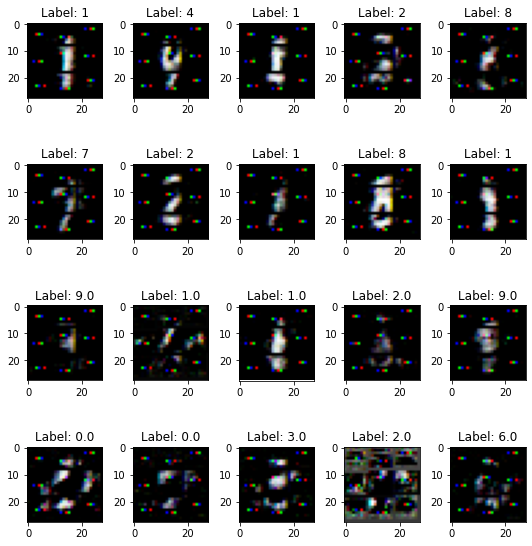

In [13]:
num_row = 4
num_col = 5
num = 10
images = source_reconstrueted[:num]
labels = source_label[:num]

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    image = images[i - 10].reshape(28,28,3)
    ax.imshow(image, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))


images = target_reconstructed[:num]
labels = target_label[:num]
for i in range(10,20):
    ax = axes[i//num_col, i%num_col]
    image = images[i - 10].reshape(28,28,3)
    ax.imshow(image, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i - 10]))
plt.tight_layout()
plt.show()

In [14]:
source_tranformed_data = data_visualization.tsne(source_reconstrueted, 2, 0.1, type = "mnist")

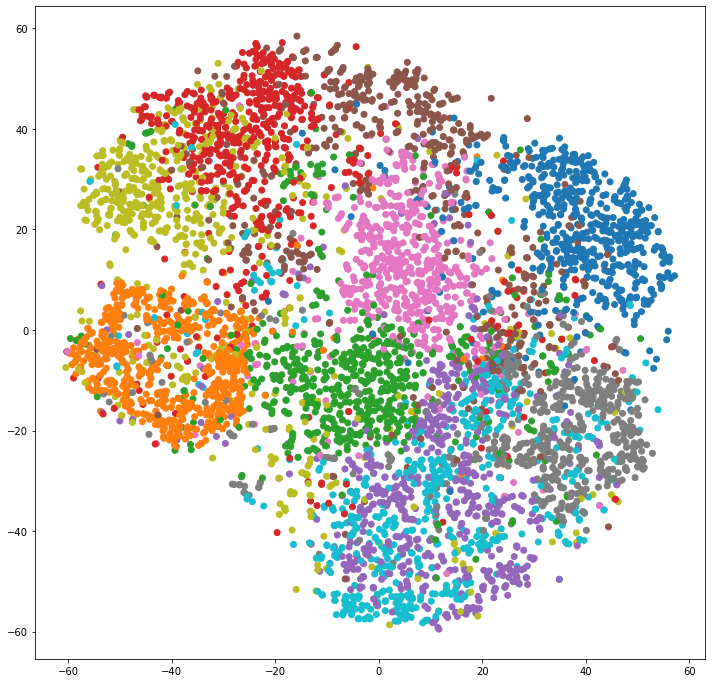

In [15]:
data_visualization.plot_info(source_tranformed_data, source_label, 2)

In [16]:
target_tranformed_data = data_visualization.tsne(target_reconstructed, 2, 0.1, type = "mnist-m")

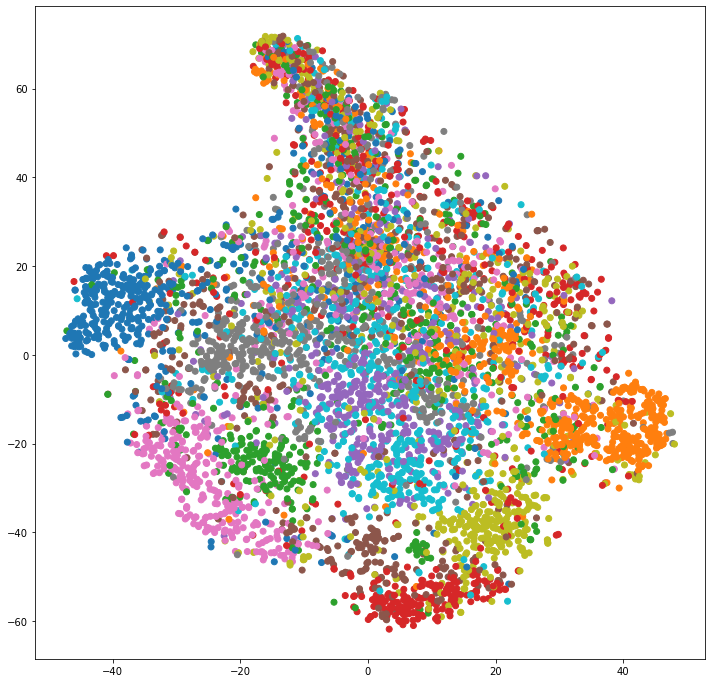

In [17]:
data_visualization.plot_info(target_tranformed_data, target_label, 2)